# Mapping QTL in BXD mice using R/qtl2

[Karl Broman](https://kbroman.org)
[<img style="display:inline-block;" src="https://orcid.org/sites/default/files/images/orcid_16x16(1).gif">](https://orcid.org/0000-0002-4914-6671),
[Department of Biostatistics & Medical Informatics](https://www.biostat.wisc.edu), 
[University of Wisconsin&ndash;Madison](https://www.wisc.edu)

Our aim in this tutorial is to demonstrate how to map quantitative trait loci (QTL) in the BXD mouse recombinant inbred lines using the [R/qtl2](https://kbroman.org/qtl2) software. We will first show how to download BXD phenotypes from [GeneNetwork2](http://gn2.genenetwork.org) using its API, via the R package [R/GNapi](https://github.com/rqtl/GNapi). At the end, we will use the [R/qtl2browse](https://github.com/rqtl/qtl2browse) package to display genome scan results using the [Genetics Genome Browser](https://github.com/chfi/purescript-genome-browser).

## Acquiring phenotypes with the GeneNetwork API

We will first use the [GeneNetwork2](http://gn2.genenetwork.org) API to acquire BXD phenotypes to use for mapping. We will use the R package [R/GNapi](https://github.com/rqtl/GNapi). 

We first need to install the package from its [GitHub](https://github.com) repository. To do so, we need the [devtools](https://github.com/r-lib/devtools) package.

```r
install.packages("devtools")
```

We then load the devtools package and install the R/GNapi package with `install_github()`.

```r
library(devtools)
install_github("rqtl/GNapi")
```

In [1]:
library(GNapi)

In [2]:
phe <- get_pheno("BXD", "10015")
head(phe)

,data_id,sample_name,sample_name_2,se,value
,<int>,<chr>,<chr>,<dbl>,<dbl>
BXD1,8967057,BXD1,BXD1,0.17,4.81
BXD11,8967057,BXD11,BXD11,0.25,8.39
BXD12,8967057,BXD12,BXD12,0.26,4.71
BXD13,8967057,BXD13,BXD13,NA,4.43
BXD14,8967057,BXD14,BXD14,0.06,4.83
BXD15,8967057,BXD15,BXD15,0.26,8.33


In [3]:
pheno <- tapply(phe$value, phe$sample_name, median)
head(pheno)

BXD1 BXD11 BXD12 BXD13 BXD14 BXD15 
 4.81  8.39  4.71  4.43  4.83  8.33

## Acquire genotype data with R/qtl2

We now want to get genotype data for the BXD panel. We first need to install the [R/qtl2](https://kbroman.org/qtl2) package. It is not available on CRAN, but rather is distributed via a private repository. But we can still use `install.packages()` to install it.

```r
install.packages("qtl2", repos="http://rqtl.org/qtl2cran")
```

We then load the package with `library()`.

In [4]:
library(qtl2)

In [5]:
bxd_file <- "https://raw.githubusercontent.com/rqtl/qtl2data/master/BXD/bxd.zip"
bxd <- read_cross2(bxd_file)

Warning message in recode_geno(sheet, genotypes):
“117497 genotypes treated as missing: "H"”

In [6]:
gmap <- insert_pseudomarkers(bxd$gmap, step=0.2, stepwidth="max")

In [7]:
pmap <- interp_map(gmap, bxd$gmap, bxd$pmap)

In [8]:
pr <- calc_genoprob(bxd, gmap, error_prob=0.002, map_function="c-f")

In [9]:
k <- calc_kinship(pr, "loco")

In [10]:
out <- scan1(pr, pheno, k)

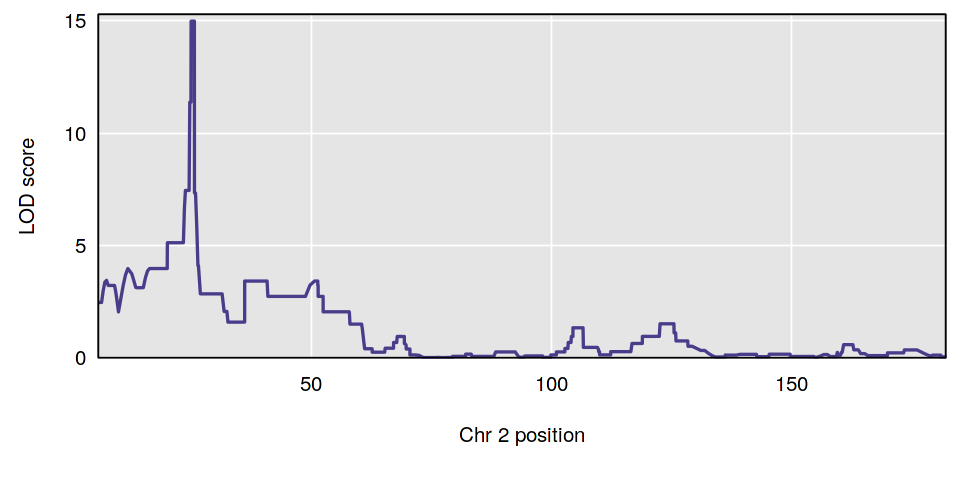

In [11]:
library(repr)
options(repr.plot.height=4, repr.plot.width=8)
par(mar=c(5.1, 4.1, 0.6, 0.6))
plot(out, pmap, chr=2)

In [12]:
mx <- max(out, pmap)
g_imp <- maxmarg(pr, pmap, chr="2", pos=mx$pos, return_char=TRUE)

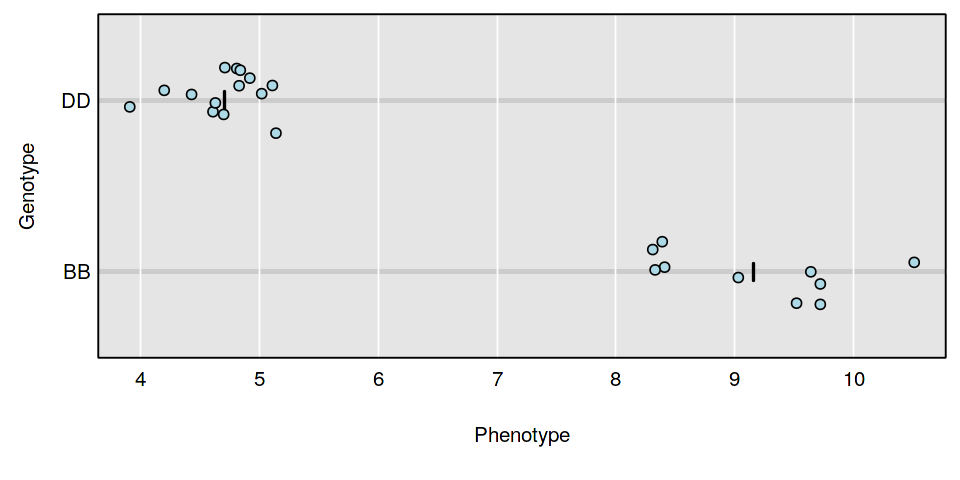

In [13]:
par(mar=c(5.1, 4.1, 0.6, 0.6))
plot_pxg(g_imp, pheno, swap_axes=TRUE)

## Browse genome scan results with Genetics Genome Browser

The [Genetics Genome Browser](https://github.com/chfi/purescript-genome-browser) is a fast, lightweight, [purescript]-based genome browser developed for browsing GWAS or QTL analysis results. We'll use the R package [R/qtl2browse](https://github.com/rqtl/qtl2browse) to view our QTL mapping results in the GGB.

We first need to install the R/qtl2browse package using `devtools::install_github()`.

```r
library(devtools)
install_github("rqtl/qtl2browse")
```

We then load the package and use its one function, `browse()`, which takes the `scan1()` output and corresponding physical map (in Mbp). This will open the Genetics Genome Browser in a separate tab in your web browser.

In [14]:
library(qtl2browse)
browse(out, pmap)